<a href="https://colab.research.google.com/github/melaniefarneti/trabajofinal_farnetimelanie/blob/main/demografico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos de tabla Demográfico


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import files
from google.colab import drive

# Para poder traer los datos desde drive.
drive.mount('/content/drive')

Mounted at /content/drive


## Extracción

In [ ]:
# Definir las rutas a los archivos (.XPT)
file_paths = [
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2000/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2002/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2004/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2006/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2008/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2010/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2012/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2014/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2016/demografico/demografico.xpt',
    '/content/drive/MyDrive/trabajofinal_farnetimelanie/nhanes_datos/2018/demografico/demografico.xpt',
]

# Cargar cada archivo como un dataframe en una lista
dfs = [pd.read_sas(file) for file in file_paths]

## Transformación

#### Filtrar columnas de interés

In [ ]:
# Seleccionar solo las columnas de interés
variables_interes = [
    'SEQN',      # Número de secuencia del encuestado
    'RIDAGEYR',  # Edad en años
    'RIDRETH1',  # Raza/Etnicidad
    'RIDEXPRG',  # Estado de embarazo
    'DMDEDUC3',  # Nivel educativo 1
    'DMDEDUC2',  # Nivel educativo 2
    'RIAGENDR',  # Género
    'DMDMARTL',  # Estado civil
    'DMDBORN',   # País de nacimiento
    'INDHHINC'   # Ingreso familiar anual
]

# Años correspondientes a cada DataFrame
year = [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018]

# Crear un diccionario para almacenar los DataFrames filtrados
dataframes = {}

# Filtrar solo las variables de interés y asignar la columna de año
for i, (df, year) in enumerate(zip(dfs, year)):
    filtered_df = df.loc[:, df.columns.intersection(variables_interes)].copy()
    filtered_df['año'] = year
    dataframes[f'demografico_{year}'] = filtered_df

# Concatenar todos los dataFrames en uno solo
demografico = pd.concat(dataframes.values(), axis=0)

# Verificar las primeras filas del dataFrame combinado
print(demografico)

          SEQN  RIAGENDR  RIDAGEYR  RIDRETH1  DMDBORN  DMDEDUC3  DMDEDUC2  \
0          1.0       2.0       2.0       4.0      1.0       NaN       NaN   
1          2.0       1.0      77.0       3.0      1.0       NaN       5.0   
2          3.0       2.0      10.0       3.0      3.0       3.0       NaN   
3          4.0       1.0       1.0       4.0      1.0       NaN       NaN   
4          5.0       1.0      49.0       3.0      1.0       NaN       5.0   
...        ...       ...       ...       ...      ...       ...       ...   
9249  102952.0       2.0      70.0       5.0      NaN       NaN       3.0   
9250  102953.0       1.0      42.0       1.0      NaN       NaN       3.0   
9251  102954.0       2.0      41.0       4.0      NaN       NaN       5.0   
9252  102955.0       2.0      14.0       4.0      NaN       8.0       NaN   
9253  102956.0       1.0      38.0       3.0      NaN       NaN       4.0   

      DMDMARTL  INDHHINC  RIDEXPRG   año  
0          NaN       3.0       N

### Ingeniería de características

In [ ]:
# Crear un diccionario con los nuevos nombres
nuevos_nombres = {
    'SEQN':     'id_paciente',
    'RIDAGEYR': 'edad',
    'RIDRETH1': 'raza_etnicidad',
    'RIDEXPRG': 'estado_embarazo',
    'RIAGENDR': 'genero',
    'DMDMARTL': 'estado_civil',
    'DMDBORN':  'pais_nacimiento',
    'INDHHINC': 'ingreso_familiar_anual'
}

# Renombrar las columnas en el DataFrame
demografico.rename(columns=nuevos_nombres, inplace=True)

In [ ]:
# Recodificación de la variable Nivel educativo
# Reemplazar valores en DMDEDUC3 según las especificaciones
demografico['DMDEDUC3'] = demografico['DMDEDUC3'].replace({
    55: 5,
    5: 6,
    6: 7,
    7: 8,
    8: 9,
    9: 11,
    66: 10,
    10: 12,
    11: 13,
    12: 14,
    13: 16,
    14: 16,
    15: 16,
    77: np.nan,
    99: np.nan
})

# Reemplazar valores en DMDEDUC2 según las especificaciones
demografico['DMDEDUC2'] = demografico['DMDEDUC2'].replace({
    1: 10,
    2: 14,
    3: 16,
    4: 17,
    5: 17,
    7: np.nan,
    9: np.nan
})

# Unificar variables en nivel_educativo
demografico['nivel_educativo'] = demografico['DMDEDUC2'].combine_first(demografico['DMDEDUC3'])
demografico = demografico.drop(['DMDEDUC2', 'DMDEDUC3'], axis=1)

# Función para imputar el nivel educativo
def imputar_nivel_educativo(edad):
    if edad < 6:
        return 0  # Jardín de infantes
    elif edad == 6:
        return 1  # 1er grado
    elif edad == 7:
        return 2  # 2do grado
    elif edad == 8:
        return 3  # 3er grado
    elif edad == 9:
        return 4  # 4to grado
    elif edad == 10:
        return 5  # 5to grado
    elif edad == 11:
        return 6  # 6to grado
    elif edad == 12:
        return 7  # 7mo grado
    elif edad == 13:
        return 8  # 8vo grado
    elif edad == 14:
        return 9  # 9no grado
    elif edad == 15:
        return 10  # 10mo grado
    elif edad == 16:
        return 11  # 11mo grado
    elif edad == 17:
        return 12  # 12º grado, sin diploma
    return None  # Deja como está si no aplica

demografico['nivel_educativo'] = demografico.apply(lambda row: imputar_nivel_educativo(row['edad'])
                                                  if pd.isnull(row['edad']) else row['nivel_educativo'], axis=1)

In [ ]:
# Reemplazar valores en País de nacimiento
demografico['pais_nacimiento'] = demografico['pais_nacimiento'].replace({7: np.nan, 9: np.nan})

# Reemplazar valores en Estado civil
demografico['estado_civil'] = demografico['estado_civil'].replace({77: np.nan, 99: np.nan})

# Función para imputar el estado civil
def imputar_estado_civil(edad):
    if edad < 18:
        return 5  # Valor para menores de 18 años
    return None  # Deja como está si no aplica

demografico['estado_civil'] = demografico.apply(lambda row: imputar_estado_civil(row['edad'])
                                                 if pd.isnull(row['estado_civil']) else row['estado_civil'], axis=1)

# Reemplazar valores en Estado de embarazo para hombres
demografico.loc[(demografico['genero'] == 1) & (demografico['estado_embarazo'] != 2), 'estado_embarazo'] = 2
demografico['estado_embarazo'] = demografico['estado_embarazo'].replace({3: np.nan})

In [ ]:
# Recodificación de la variable Ingreso familiar anual
demografico['ingreso_familiar_anual'] = demografico['ingreso_familiar_anual'].replace({
    13: 5,
    12: 7,
    5: 6,
    6: 8,
    7: 9,
    8: 10,
    9: 11,
    10: 12,
    11: 13
})

demografico['ingreso_familiar_anual'] = demografico['ingreso_familiar_anual'].replace({77: np.nan, 99: np.nan})

### Nulos

In [ ]:
demografico.isnull().sum()

,0
id_paciente,0
genero,0
edad,0
raza_etnicidad,0
pais_nacimiento,59871
estado_civil,2420
ingreso_familiar_anual,63546
estado_embarazo,33537
año,0
nivel_educativo,16891


In [ ]:
# Separación de features en numéricas, binarias y categóricas.
# Numéricas
num_feats = ['id_paciente', 'edad_en_años']
# Categóricas binarias
bin_feats = ['estado_embarazo', 'genero']
# Categóricas Multi-
nom_feats = ['raza_etnicidad', 'estado_civil', 'pais_nacimiento', 'ingreso_familiar_anual', 'nivel_educativo']
cat_feats = nom_feats + bin_feats

In [ ]:
# Asegurarse de que las columnas contengan valores enteros
for column in cat_feats:
    # Reemplaza NaN por un valor temporal, asegurando que la conversión sea segura
    demografico[column] = demografico[column].fillna(-1)

    # Convertir a enteros
    demografico[column] = demografico[column].astype(int)
    demografico[column] = demografico[column].replace(-1, pd.NA)  # Cambia -1 de vuelta a NaN

# Finalmente, convierte a tipo 'category'
for column in cat_feats:
    demografico[column] = demografico[column].astype('category')

In [ ]:
demografico.info()
demografico.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 101316 entries, 0 to 9253
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   id_paciente             101316 non-null  float64 
 1   genero                  101316 non-null  category
 2   edad                    101316 non-null  float64 
 3   raza_etnicidad          101316 non-null  category
 4   pais_nacimiento         41445 non-null   category
 5   estado_civil            98896 non-null   category
 6   ingreso_familiar_anual  37770 non-null   category
 7   estado_embarazo         67779 non-null   category
 8   año                     101316 non-null  int64   
 9   nivel_educativo         84425 non-null   category
dtypes: category(7), float64(2), int64(1)
memory usage: 3.8 MB


,0
id_paciente,0
genero,0
edad,0
raza_etnicidad,0
pais_nacimiento,59871
estado_civil,2420
ingreso_familiar_anual,63546
estado_embarazo,33537
año,0
nivel_educativo,16891


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# Definir las columnas con valores nulos
cols_con_nulos = ['pais_nacimiento', 'estado_civil', 'ingreso_familiar_anual', 'estado_embarazo', 'nivel_educativo']

# 1. Imputación con Árbol de Decisión
demografico_dt = demografico.copy()
for col in cols_con_nulos:
    # Filtrar las filas donde el valor está nulo
    indices_nulos = demografico[demografico[col].isnull()].index
    # Crear un conjunto de entrenamiento excluyendo las filas con valores nulos en la columna
    data_train_dt = demografico.dropna(subset=[col])

    # Dividir en X (predictores) y y (variable objetivo)
    y_train = data_train_dt[col]
    X_train = data_train_dt.drop(cols_con_nulos, axis=1)

    # Predecir los valores nulos
    X_test = demografico.loc[indices_nulos].drop(cols_con_nulos, axis=1)
    dt_imputer = DecisionTreeClassifier()
    dt_imputer.fit(X_train, y_train)

    # Obtener las predicciones
    data_test_dt = dt_imputer.predict(X_test)

    # Asignar las predicciones a las filas con valores nulos en la columna original
    demografico_dt.loc[indices_nulos, col] = data_test_dt

In [ ]:
demografico_dt.isnull().sum()

,0
id_paciente,0
genero,0
edad,0
raza_etnicidad,0
pais_nacimiento,0
estado_civil,0
ingreso_familiar_anual,0
estado_embarazo,0
año,0
nivel_educativo,0


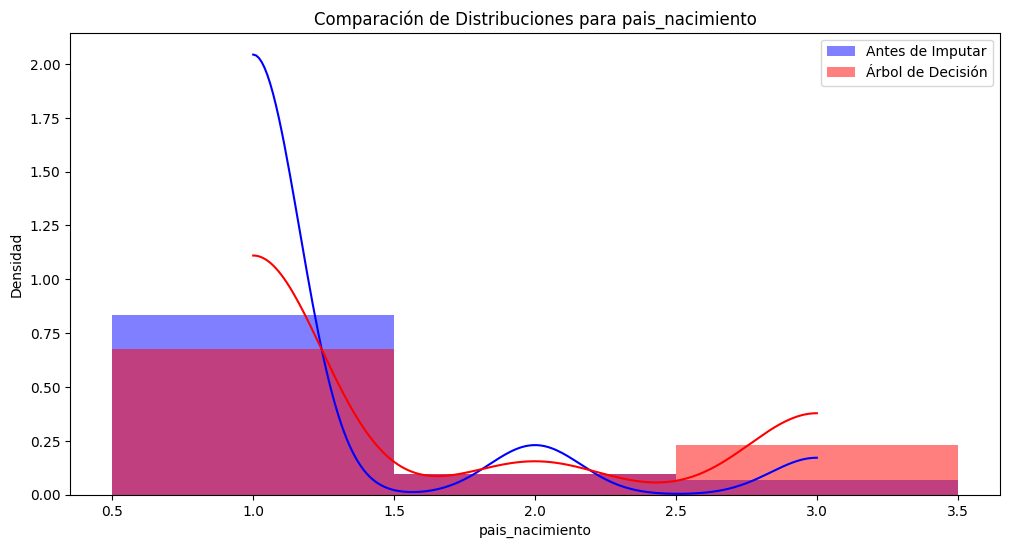

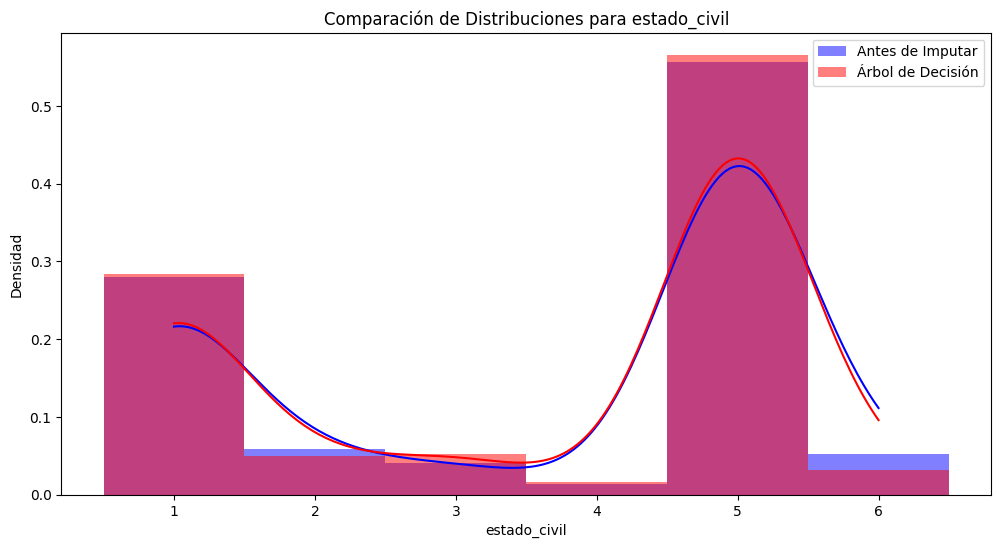

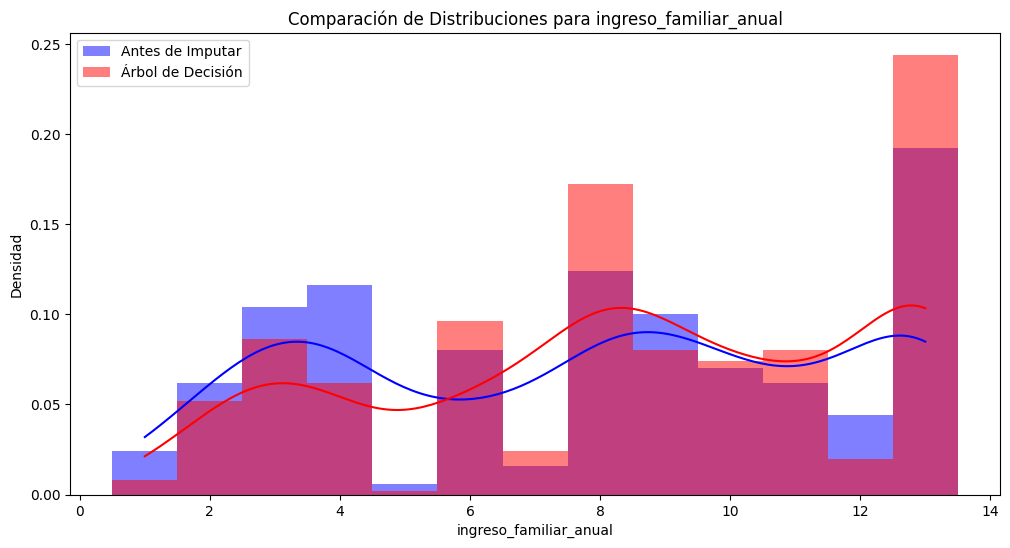

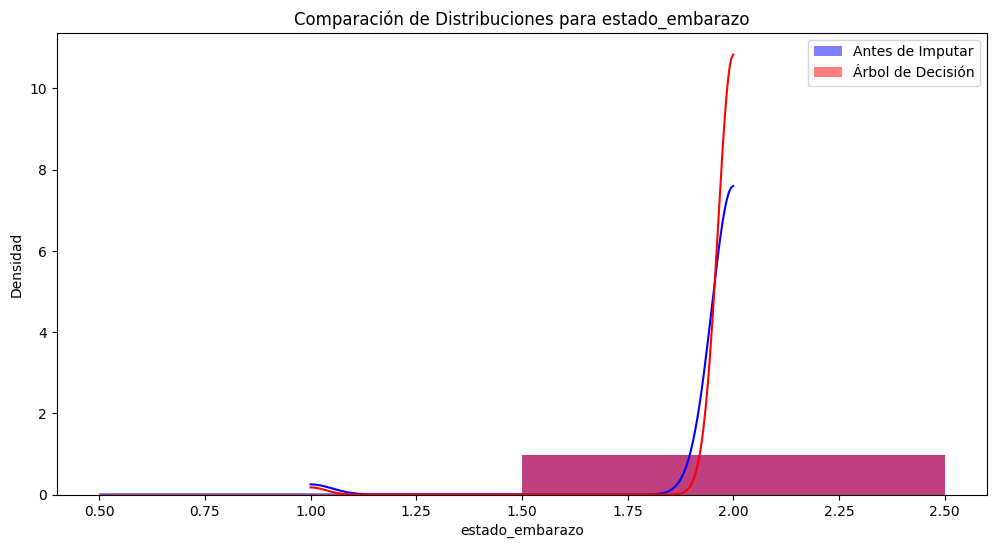

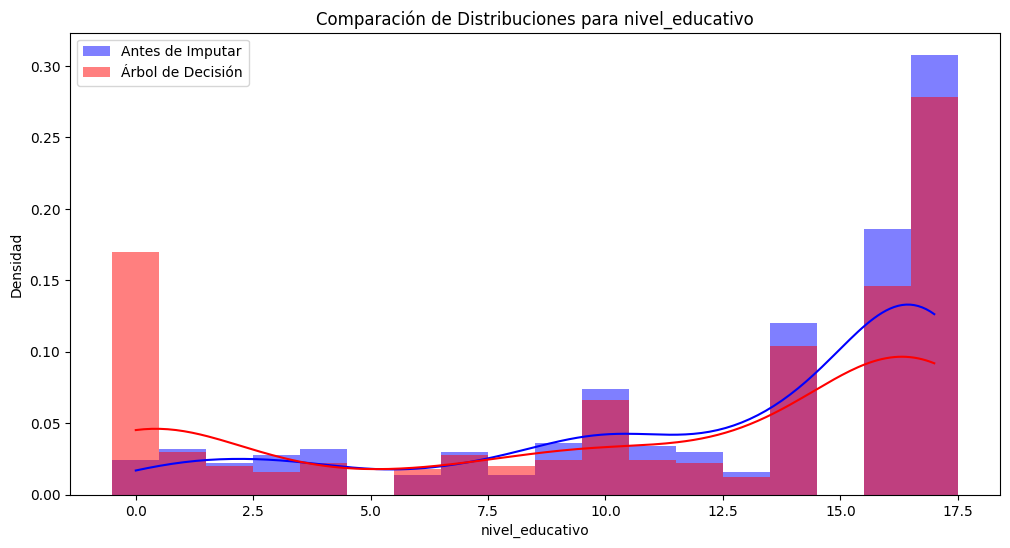

In [ ]:
# Crear los gráficos comparativos de la distribución de las variables antes y después de la imputación
for col in cols_con_nulos:
    plt.figure(figsize=(12, 6))

    # Mostrar la distribución antes de la imputación (con nulos)
    sns.histplot(demografico[col].dropna().sample(500), kde=True, color='blue', label='Antes de Imputar', stat='density', linewidth=0)

    # Después imputación con Árbol de Decisión
    sns.histplot(demografico_dt[col].dropna().sample(500), kde=True, color='red', label='Árbol de Decisión', stat='density', linewidth=0)

    # Añadir etiquetas y leyenda
    plt.title(f'Comparación de Distribuciones para {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Densidad')
    plt.legend()
    plt.show()


## Carga

In [ ]:
# Guarda el dataframe demografico.csv
demografico.to_csv('demografico.csv', index=False)

# Descarga el archivo CSV a tu máquina local
from google.colab import files
files.download('demografico.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>